# Google Notebook specific Stuff

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install pytorch-lightning==1.3.3
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl
!pip install scGeneFit
!pip install scanpy
!pip install anndata
!pip install lassonet
# my version of smashpy that fixed imports, nothing else was changed
!pip install matplotlib>=3.3.2
!pip install shap>=0.37.0
!pip install xgboost>=1.3.3
!pip install imbalanced-learn>=0.7.0
!pip install numba>=0.51.2
!pip install harmonypy>=0.0.5
!pip install smashpy
!git clone https://github.com/ahsv/RankCorr.git

fatal: destination path 'RankCorr' already exists and is not an empty directory.


In [ ]:
# Check GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [ ]:
import sys
import os
# to import utils
sys.path.append(os.path.abspath('/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/notebooks'))

# All the Imports

In [ ]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from lassonet import LassoNetClassifier


from RankCorr.picturedRocks import Rocks
import smashpy as smashpy


import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *


CPU times: user 21.8 s, sys: 1.54 s, total: 23.3 s
Wall time: 27.8 s


# These should be parameters later on 

In [ ]:
z_size = 16
hidden_layer_size = 256

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 50, 100, 250]
k = 50
num_times = 5

gpus = 1
tpu_cores = None

In [ ]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

# Here goes all the stuff that we change from dataset to dataset

In [ ]:
from os import path

In [ ]:
dataset_dir = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/zeisel/'
model_save_path = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/zeisel/models/'
viz_save_path = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/zeisel/visualizations/'

if not path.exists(model_save_path):
  os.mkdir(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.mkdir(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.mkdir(viz_save_path)

  

# Dataset Specific Processing

`

In [ ]:
adata = sc.read_h5ad(dataset_dir + "Zeisel.h5ad")

In [ ]:
adata.obs

,names0,names1,labels0,labels1
0,interneurons,Int10,3,12
1,interneurons,Int10,3,12
2,interneurons,Int6,3,23
3,interneurons,Int10,3,12
4,interneurons,Int9,3,26
...,...,...,...,...
3000,endothelial-mural,Peric,2,35
3001,endothelial-mural,Vsmc,2,48
3002,endothelial-mural,Vsmc,2,48
3003,endothelial-mural,Vsmc,2,48


In [ ]:
adata.shape

(3005, 4000)

In [ ]:
np.apply_along_axis(np.mean, 0, adata.X)

array([5.07780e-09, 4.06224e-08, 0.00000e+00, ..., 4.06224e-08,
       3.04668e-08, 0.00000e+00], dtype=float32)

In [ ]:
np.apply_along_axis(np.var, 0, adata.X)

array([0.9996673, 0.9996672, 0.9996674, ..., 0.9996672, 0.9996674,
       0.9996673], dtype=float32)

In [ ]:
X = adata.X.copy()
adata.obs['names']=adata.obs['names0']
adata.obs['annotation'] = adata.obs['names0']
labels = adata.obs['names0'].values
encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

In [ ]:
input_size = X.shape[1]
y

array([2, 2, 2, ..., 1, 1, 1])

In [ ]:
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

In [ ]:

import utils_soledad 
from importlib import reload  
reload(utils_soledad)
from utils_soledad import *

error_rates=[0] # 0.1, 0.2, 0.3, 0.4, 0.5]
methods=["l1_vae", "random", "runningstate", "rankcorr"] #, "smash_rf", "smash_DNN",  "runningstate_vae", "concrete_vae", "globalgate"]
accuracy=np.zeros((len(methods), len(error_rates)))

X = adata.X.copy()
y = y.copy()
train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
X_train = X[np.concatenate([train_indices, val_indices]), :]
y_train = y[np.concatenate([train_indices, val_indices])]
X_test = X[test_indices,:]
y_test = y[test_indices]

for j in range(len(error_rates)):
    data = noisy_adata(adata, error_rates[j])
    for i in range(len(methods)):
        if accuracy[i,j]==0:
            markers = get_markers(data, 25, method=methods[i], params={})
            results = new_model_metrics(X_train, y_train, X_test, y_test, markers)
            accuracy[i,j]=results[1]["accuracy"]
        print("********",i,j, accuracy[i,j])

accuracy

In [ ]:
accuracy

# Set Up Models

## Baseline

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



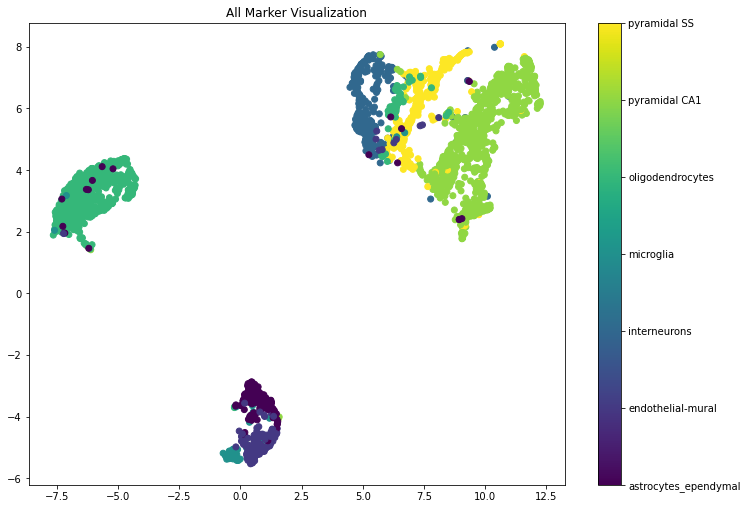

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



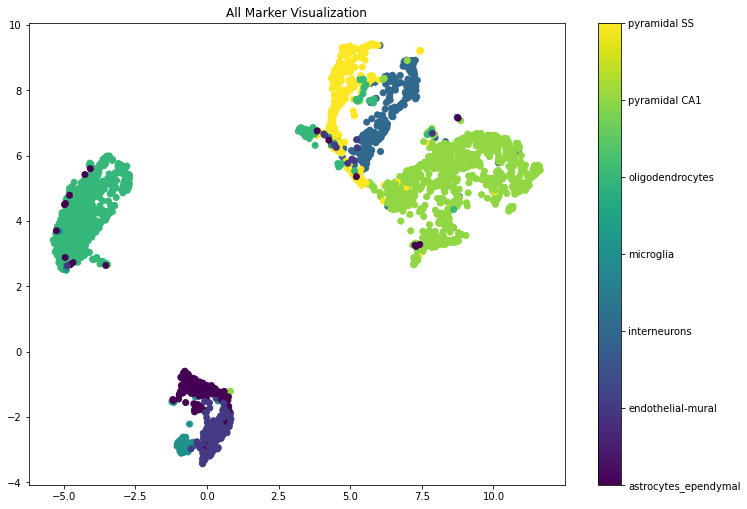

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



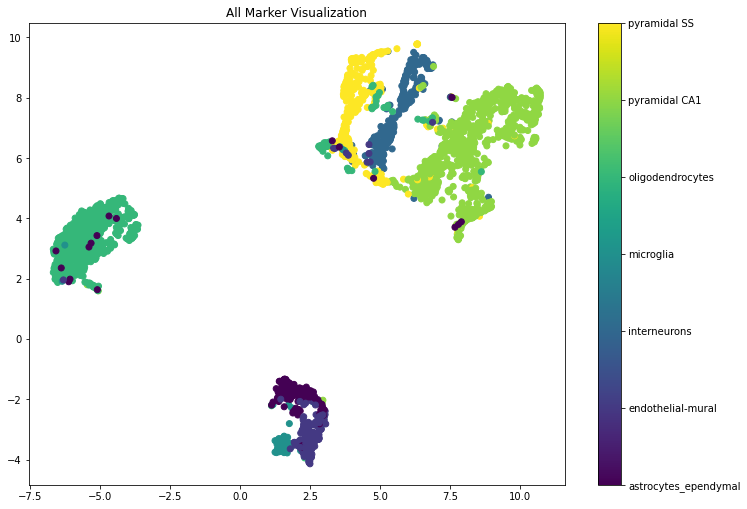

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



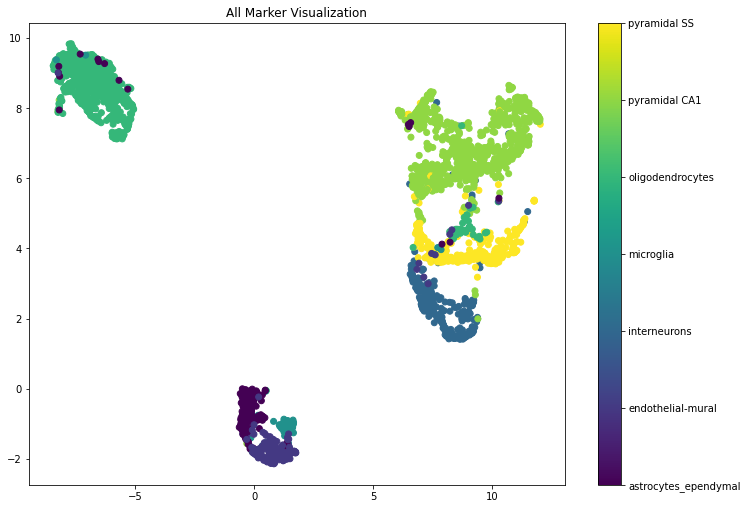

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



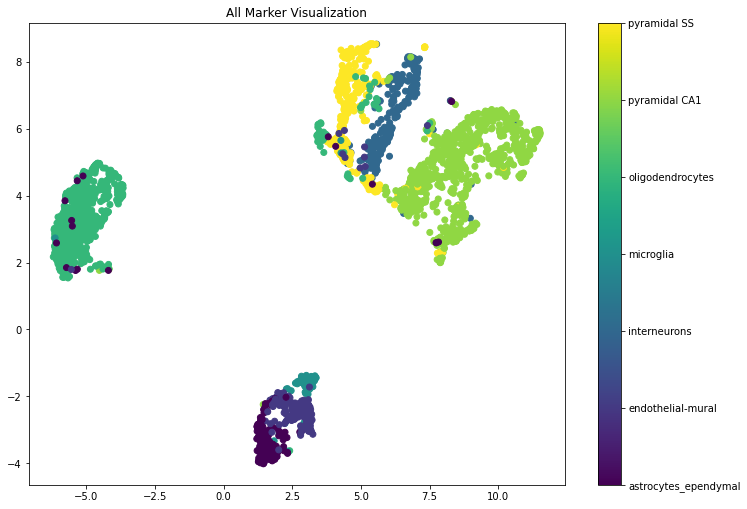

CPU times: user 3min 10s, sys: 2.2 s, total: 3min 12s
Wall time: 2min 42s


In [ ]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    all_markers = np.arange(X.shape[1])
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = all_markers)
    np.save(model_save_path + 'all_markers_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'all_markers_{}.npy'.format(tryy), all_markers)
    np.save(model_save_path + 'experiment_data_folds/all_markers_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'All Marker Visualization', path = viz_save_path + 'all_markers_{}.pdf'.format(tryy), markers = all_markers)


## Train Smash Random Forest





In [ ]:
# needed for random forest Smash
!mkdir Figures

In [ ]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_{}.png'.format(tryy), markers = smash_markers)

In [ ]:
results

## Train Smash DNN

the data is treated a bit differently than our other models

In [ ]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(adata, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(adata, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_{}.png'.format(tryy), markers = smash_markers)

In [ ]:
results

## Train RankCorr

In [ ]:
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = 4.7# this can be whatever

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        print("Excess Length of markers")
        print(len(rankcorr_markers))
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_{}.png'.format(tryy), markers = rankcorr_markers)

In [ ]:
len(rankcorr_markers)

In [ ]:
print("Some, if not all, selected gene names")
print(marker_genes)

In [ ]:
results

## Train L1 VAE

In [ ]:
feature_std = torch.tensor(X).std(dim = 0)
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = 16)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_{}.png'.format(tryy), markers = l1_markers)

In [ ]:
results

## Train Global Gate

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_{}.png'.format(tryy), markers = globalgate_markers)

In [ ]:
model.t

In [ ]:
results

## Train Running State VAE

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = VAE_Gumbel_RunningState(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    runningstate_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = runningstate_markers)
    np.save(model_save_path + 'runningstate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'runningstate_vae_markers_{}.npy'.format(tryy), runningstate_markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State VAE Marker Visualization', path = viz_save_path + 'runningstate_vae_markers_{}.png'.format(tryy), markers = runningstate_markers)

In [ ]:
model.t

In [ ]:
results

In [ ]:
model.t

## Running State Classifier

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = GumbelClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_classifier_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = 16, lr_explore_mode = 'linear', num_lr_rates=500)
    runningstate_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = runningstate_markers)
    np.save(model_save_path + 'runningstate_classifier_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'runningstate_classifier_markers_{}.npy'.format(tryy), runningstate_markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_classifier_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State Classifier Marker Visualization', path = viz_save_path + 'runningstate_classifier_markers_{}.png'.format(tryy), markers = runningstate_markers)

In [ ]:
model.lr

In [ ]:
model.t

In [ ]:
model.hparams.lr

In [ ]:
results

## RunningState VAE + Classifier

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = RunningState_VAE_Classifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_vae+classifier_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = 16, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'runningstate_vae+classifier_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'runningstate_vae+classifier_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_vae+classifier_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State VAE+Classifier Marker Visualization', path = viz_save_path + 'runningstate_vae+classifier_markers_{}.png'.format(tryy), markers = markers)

In [ ]:
results

## Concrete VAE

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_{}.png'.format(tryy), markers = concrete_vae_markers)

In [ ]:
results = np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)

In [ ]:
results

## LassoNet



In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
from functools import partial
from lassonet import plot_path

In [ ]:
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier()
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers)

In [ ]:
results

## Get Model Metrics from KNNs Classifiers


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/all_markers_indices_{}.npy',
                                  model_save_path+'all_markers_{}.npy',
                                  model_save_path+'all_markers_knn_results_{}.npy')


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_vae_indices_{}.npy',
                                  model_save_path+'runningstate_vae_markers_{}.npy',
                                  model_save_path+'runningstate_vae_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_classifier_indices_{}.npy',
                                  model_save_path+'runningstate_classifier_markers_{}.npy',
                                  model_save_path+'runningstate_classifier_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_vae+classifier_indices_{}.npy',
                                  model_save_path+'runningstate_vae+classifier_markers_{}.npy',
                                  model_save_path+'runningstate_vae+classifier_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

# Results and Visualizations

## Accuracies and F1

In [ ]:
result_axis = [
 ('All Markers', 'all_markers_results_{}.npy', 'all_markers_knn_results_{}.npy'), 
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('RunningGumbel VAE', 'runningstate_vae_results_{}.npy', 'runningstate_vae_knn_results_{}.npy'),
 ('RunningGumbel Classifier', 'runningstate_classifier_results_{}.npy', 'runningstate_classifier_knn_results_{}.npy'),
 ('RunningGumbel VAE+Classifier', 'runningstate_vae+classifier_results_{}.npy', 'runningstate_vae+classifier_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [ ]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [ ]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

,Misclassification Mean,Weighted F1 Mean,Misclassification Standard Deviation,Weighted F1 Standard Deviation
All Markers,0.046256,0.952297,0.011157,0.011810
L1 VAE,0.235275,0.742800,0.046525,0.053985
Smash RF,0.048918,0.950326,0.008652,0.008808
SMaSH DNN,0.080200,0.917809,0.024845,0.026389
RankCorr,0.053245,0.946112,0.006226,0.006405
Global Gate VAE,0.202662,0.783416,0.027910,0.029794
RunningGumbel VAE,0.155408,0.834829,0.047561,0.052798
RunningGumbel Classifier,0.049251,0.950074,0.006949,0.007240
RunningGumbel VAE+Classifier,0.055574,0.943295,0.010235,0.011192
Concrete VAE,0.198336,0.790514,0.020659,0.022614


In [ ]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [ ]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

,Misclassification Mean,Weighted F1 Mean,Misclassification Standard Deviation,Weighted F1 Standard Deviation
All Markers,0.049584,0.949909,0.008246,0.008434
L1 VAE,0.308153,0.677239,0.047999,0.054186
Smash RF,0.054908,0.944510,0.006656,0.006786
SMaSH DNN,0.093511,0.903959,0.040626,0.043140
RankCorr,0.055574,0.943303,0.007704,0.008015
Global Gate VAE,0.274542,0.713428,0.020702,0.021434
RunningGumbel VAE,0.185358,0.806042,0.061168,0.065708
RunningGumbel Classifier,0.039933,0.959765,0.007059,0.007135
RunningGumbel VAE+Classifier,0.067221,0.931077,0.013000,0.013883
Concrete VAE,0.271880,0.710892,0.028677,0.032507


## Confusion Matrices

k = 50

### All Marker Baseline

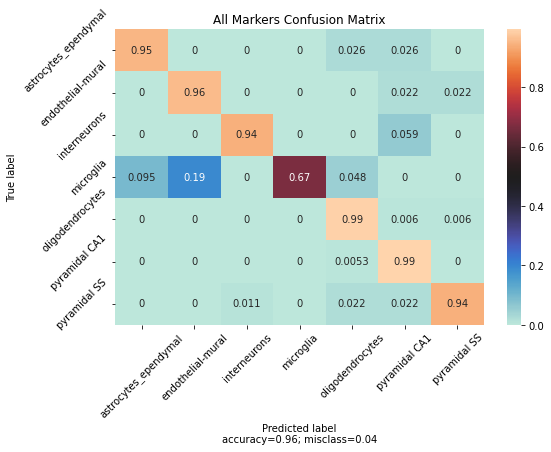

In [ ]:
results =  np.load(model_save_path + 'all_markers_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'All Markers Confusion Matrix', save_path = viz_save_path + 'all_markers_cm.pdf', cmap = 'icefire')

### Smash RF

In [ ]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

In [ ]:
results

array([0.03161397670549082,
       {'0': {'precision': 0.9215686274509803, 'recall': 0.9591836734693877, 'f1-score': 0.9400000000000001, 'support': 49}, '1': {'precision': 0.9722222222222222, 'recall': 0.8333333333333334, 'f1-score': 0.8974358974358975, 'support': 42}, '2': {'precision': 1.0, 'recall': 0.9649122807017544, 'f1-score': 0.9821428571428572, 'support': 57}, '3': {'precision': 1.0, 'recall': 0.8695652173913043, 'f1-score': 0.9302325581395349, 'support': 23}, '4': {'precision': 0.9764705882352941, 'recall': 0.9940119760479041, 'f1-score': 0.9851632047477744, 'support': 167}, '5': {'precision': 0.972972972972973, 'recall': 0.994475138121547, 'f1-score': 0.9836065573770493, 'support': 181}, '6': {'precision': 0.9404761904761905, 'recall': 0.9634146341463414, 'f1-score': 0.9518072289156626, 'support': 82}, 'accuracy': 0.9683860232945092, 'macro avg': {'precision': 0.9691015144796656, 'recall': 0.9398423218873673, 'f1-score': 0.9529126148226823, 'support': 601}, 'weighted avg': {

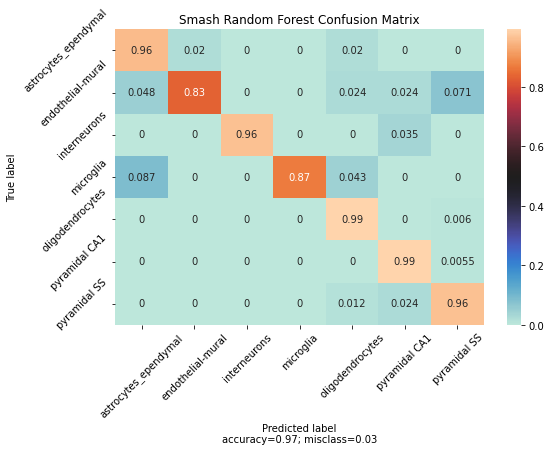

In [ ]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.pdf', cmap = 'icefire')

### Smash DNN

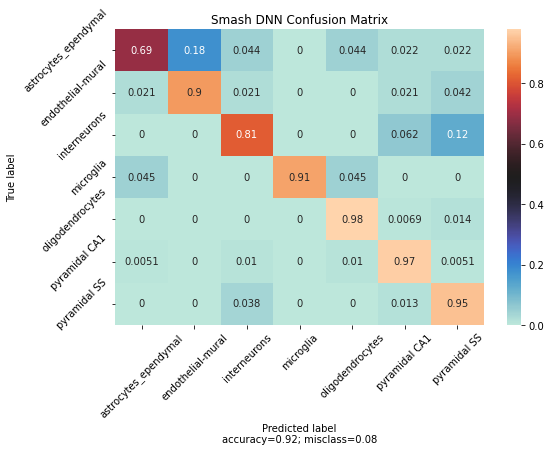

In [ ]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.pdf', cmap = 'icefire')

### RankCorr

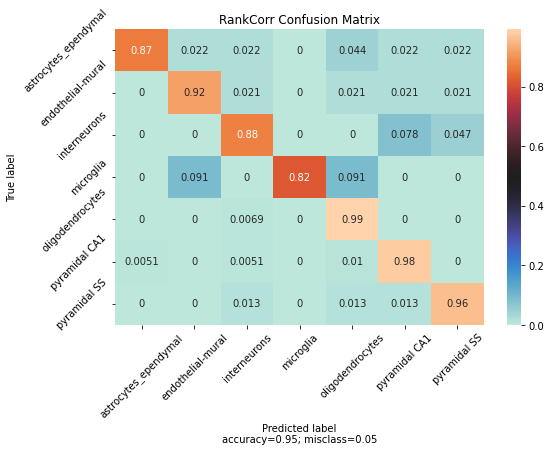

In [ ]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.pdf', cmap = 'icefire')

### L1 VAE

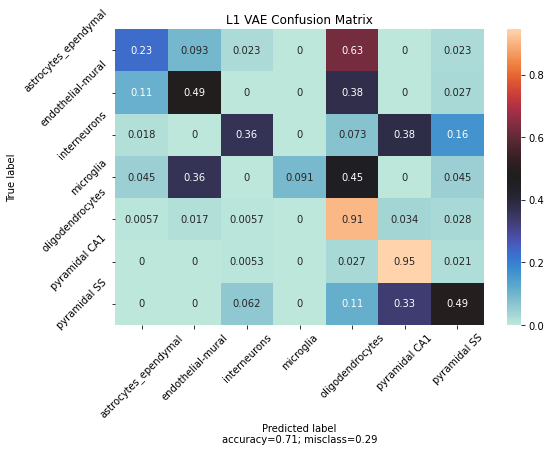

In [ ]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.pdf', cmap = 'icefire')

### Global Gate VAE

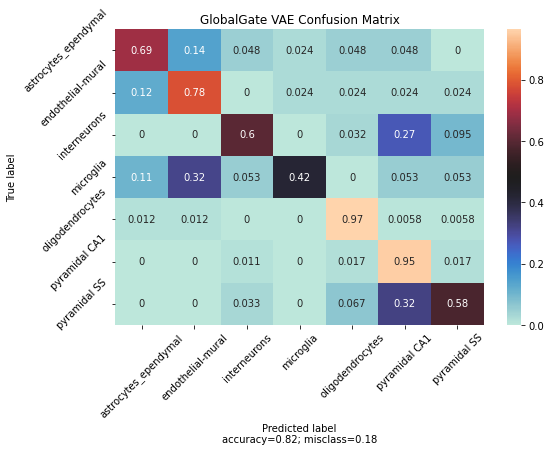

In [ ]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.pdf', cmap = 'icefire')

### Running Gumbel VAE

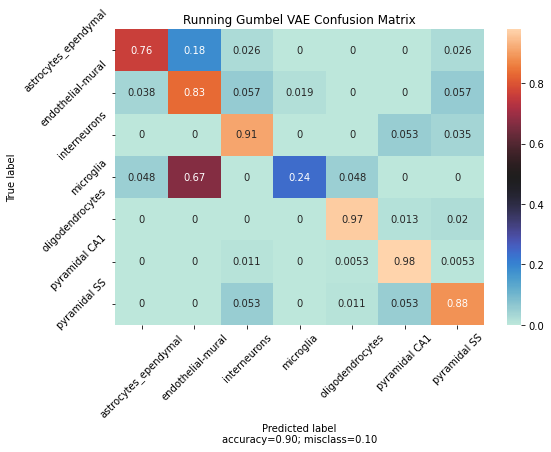

In [ ]:
results =  np.load(model_save_path + 'runningstate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel VAE Confusion Matrix', save_path = viz_save_path + 'runningstate_vae_cm.pdf', cmap = 'icefire')

### Running Gumbel Classifier


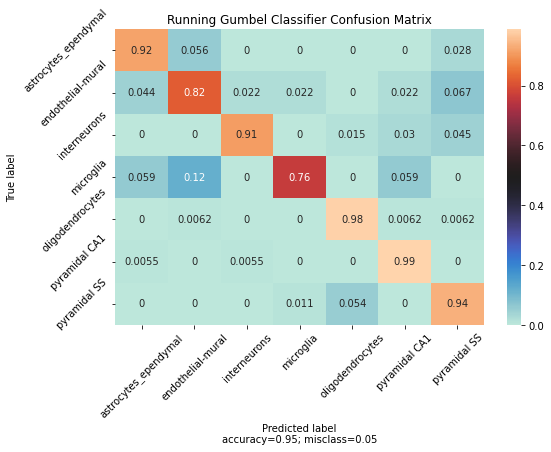

In [ ]:
results =  np.load(model_save_path + 'runningstate_classifier_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel Classifier Confusion Matrix', save_path = viz_save_path + 'runningstate_classifier_cm.pdf', cmap = 'icefire')

## RunningState VAE+Classifier

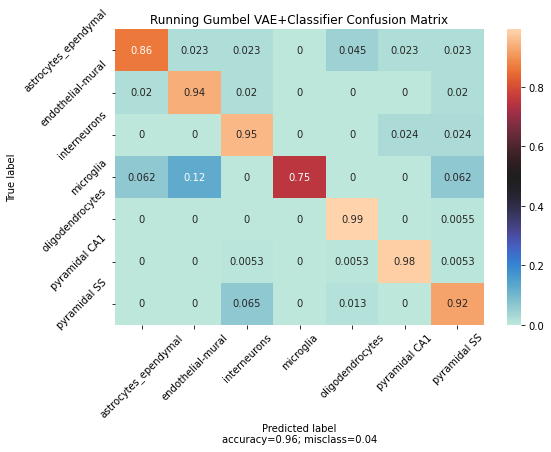

In [ ]:
results =  np.load(model_save_path + 'runningstate_vae+classifier_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel VAE+Classifier Confusion Matrix', save_path = viz_save_path + 'runningstate_vae+classifier_cm.pdf', cmap = 'icefire')

### Concrete VAE

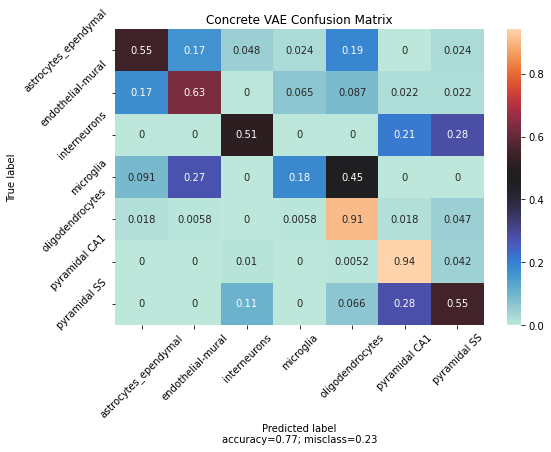

In [ ]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.pdf', cmap = 'icefire')

## LassoNet

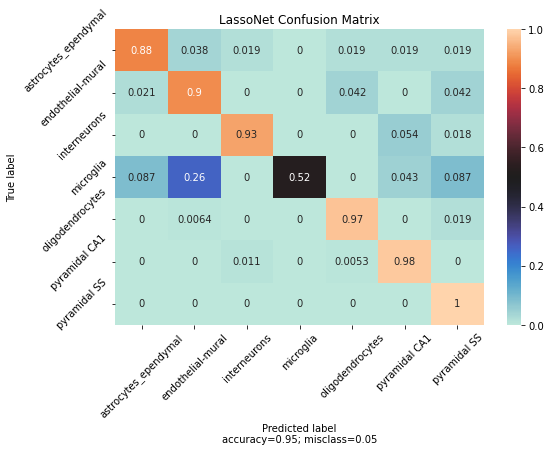

In [ ]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.pdf', cmap = 'icefire')

## UMap Visualization

In [ ]:
import cv2

In [ ]:
img = cv2.imread(viz_save_path + 'smash_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'rankcorr_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_vae_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_classifier_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_vae+classifier_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'concrete_vae_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'lasso_net_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

## Visualizing Reconstructions

from first model of each

## L1 VAE

In [ ]:
model = load_model(VAE_l1_diag, model_save_path + 'l1_vae_{}.ckpt'.format(1))
l1_vae_markers = np.load(model_save_path + 'l1_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'L1 VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_l1_vae_{}.png'.format(1), markers = l1_vae_markers)

### Global Gate VAE

In [ ]:
model = load_model(VAE_Gumbel_GlobalGate, model_save_path + 'globalgate_vae_{}.ckpt'.format(1))
globalgate_vae_markers = np.load(model_save_path + 'globalgate_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Global Gate VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_globalgate_vae_{}.png'.format(1), markers = globalgate_vae_markers)

### Running State Gumbel VAE

In [ ]:
model = load_model(VAE_Gumbel_RunningState, model_save_path + 'runningstate_vae_{}.ckpt'.format(1))


In [ ]:
runningstate_vae_markers = np.load(model_save_path + 'runningstate_vae_markers_{}.npy'.format(1), allow_pickle=True)

In [ ]:
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]

In [ ]:
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Running State VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_runningstate_vae_{}.png'.format(1), markers = runningstate_vae_markers)

RunningState VAE+Classifier

In [ ]:
model = load_model(RunningState_VAE_Classifier, model_save_path + 'runningstate_vae+classifier_{}.ckpt'.format(1))
runningstate_vae_classifier_markers = np.load(model_save_path + 'runningstate_vae+classifier_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Running State VAE+Classifier Reconstruction Marker Visualization', 
                         path = viz_save_path + 'recon_runningstate_vae+classifier_{}.png'.format(1), markers = runningstate_vae_classifier_markers)

Concrete VAE

In [ ]:
model = load_model(ConcreteVAE_NMSL, model_save_path + 'concrete_vae_{}.ckpt'.format(1))
concrete_vae_markers = np.load(model_save_path + 'concrete_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Concrete VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_concrete_vae_{}.png'.format(1), markers = concrete_vae_markers)

# Things to note for paper

PySmash uses a seed internally so the model is deterministic to a particular dataset. We used various different train seeds, whereas the smash paper uses the whole dataset for the data.

For smash DNN, to select the markers, I had to use all the data. Couldn't just use train and val set.